# Pronóstico de fallas para mantenimiento predictivo usando metodologías de aprendizaje profundo supervisado
### Francisco Araya López - Departamento de Eléctronica - UTFSM
### Turbofan Engine Simulation Dataset
### Octubre 2020

## Análisis descriptivo Turbofan Engine Degradation Simulation Dataset

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, FastICA
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

%matplotlib inline

In [ ]:
# PARAMETROS

#tamaño ventana movil maxima de cada dataset
W_H_FD001 = 30 #MAX 30
W_H_FD002 = 20 #MAX 20
W_H_FD003 = 30 #MAX 30
W_H_FD004 = 15 #MAX 15
#Numero de features 
W_W_FDXXX = 14
#Semilla para generador numeros pseudoaleatorios
SEED = 15
#Porcentaje datos entrenamiento respecto al total
T_V_SPLIT = 0.9
# Optimizer

OPTIM = "Adam"

#HIPERPARAMETROS
BATCH_SIZE_T = 512 #batch size all
EPOCHS_MAX = 5000 #EPOCHS MAX




In [ ]:
# window_h is the height of the sliding windows in the dataset
# window_w is the width of the sliding windows in the dataset
# seed is the seed of the random number generator used in shuffle function, for shuffle pairs (X,Y) before
# feed CNN in training process.
# t_v_split is the percentage of data used as training and the rest is used for validation data.

def build_train_and_test_set(path_train,path_test,path_rul,window_h,window_w,seed,t_v_split):
  
  #CREACION DE FEATURES MAPS Y RULS PARA ENTRENAMIENTO (Y VALIDACION) 

  df = pd.read_csv(path_train, sep = ' ', header = None)
  df = df.drop(columns=[26, 27])
  df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
  df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  
  #Agregada variable RUL a df y normalización de columnas (salvo RUL)
  
  RUL_temp=np.zeros(0)
  for i in range(1,df['n_engine'].max() + 1):
    minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
    RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
    RUL_temp = np.append(RUL_temp,RUL_engine-minus)
  df['RUL'] = RUL_temp
  df['RUL'] = df['RUL'].astype(int)
  scaler = MinMaxScaler(feature_range=(-1,1))
  df[df.columns[1:19]]= scaler.fit_transform(df[df.columns[1:19]])

  # Creación de features maps
  features_maps=np.empty((window_h,window_w,1))
  df_ys = np.zeros((1,1))
  
  #se obtienen los dataset de engines independientes en df_temp
  for i in range(1,df['n_engine'].max()+1):
    df_temp1 = df[df['n_engine'] == i]
    df_temp2 = df_temp1.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
    df_features = df_temp2.drop(['RUL'],axis = 1)
    df_y = df_temp2['RUL'].to_numpy()
    df_ys = np.append(df_ys,df_y[(window_h - 1):])
    for j in range(len(df_y)-(window_h - 1)):
      feature_map = df_features[j:j+(window_h)][:]
      features_maps = np.dstack((features_maps, feature_map))
  features_maps=np.delete(features_maps, 0, 2)
  df_ys = np.delete(df_ys, 0, 0)
  
  # cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
  features_maps = np.moveaxis(features_maps, 2, 0)

  # Expansion a 2 dimensiones para vector con Yverdaderos (RUL conjunto de entrenamiento) y 4 para features maps
  df_ys = np.expand_dims(df_ys,axis=1)
  features_maps= np.expand_dims(features_maps,3)

  #random para pares (X,Y) del conjunto de entrenamiento
  features_maps, df_ys = shuffle(features_maps, df_ys, random_state=seed)

  #valores de RUL mayores a 125 se seteean en 125
  #for i in range(len(df_ys)):
  #  if df_ys[i] >= 125:
  #    df_ys[i] = 125

  ys_train = df_ys[:int(len(df_ys)*(t_v_split))]
  ys_valid = df_ys[int(len(df_ys)*(t_v_split)):]

  features_maps_train = features_maps[:int(len(df_ys)*(t_v_split))]
  features_maps_valid = features_maps[int(len(df_ys)*(t_v_split)):]

  #CREACION DE FEATURES MAPS Y RULS PARA TESTEO

  df_t = pd.read_csv(path_test, sep = ' ', header = None)
  df_t = df_t.drop(columns=[26, 27])
  df_t.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
  df_t = df_t.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  df_t[df_t.columns[1:19]]= scaler.transform(df_t[df_t.columns[1:19]])

  #se obtienen los dataset de engines independientes en df_temp
  features_maps_test=np.empty((window_h,window_w,1))
  for i in range(1,df_t['n_engine'].max()+1):
    df_temp = df_t[df_t['n_engine'] == i].drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
    df_large = df_temp['sens_8'].count()
    feature_map = df_temp[df_large-(window_h):][:]
    features_maps_test = np.dstack((features_maps_test, feature_map))
  features_maps_test=np.delete(features_maps_test, 0, 2)
  
  # cambio de dimensión features maps de forma Ntimestaps,Nfeatures,M) a (M,Ntimestaps,Nfeatures)
  features_maps_test = np.moveaxis(features_maps_test, 2, 0)
  features_maps_test = np.expand_dims(features_maps_test,3)

  ruls_test= []
  rul_file = open(path_rul, "r")
  for rul_line in rul_file:
    ruls_test.append(int(rul_line.rstrip(' \n')))

  ruls_test_final = np.array(ruls_test)
  features_maps_test_final = np.array(features_maps_test)
  idx   = np.argsort(ruls_test_final)

  ruls_test_final = np.array(ruls_test_final)[idx]
  features_maps_test_final = np.array(features_maps_test_final)[idx]

  
  #for i in range(len(ruls_test_final)):
  #  if ruls_test_final[i] >= 125:
  #    ruls_test_final[i] = 125

  return ys_train, ys_valid, features_maps_train, features_maps_valid, ruls_test_final, features_maps_test_final


In [ ]:
y_train1, y_valid1, f_maps_train1, f_maps_valid1, r_test_f1, f_maps_test_f1 = (build_train_and_test_set('train_FD001.txt','test_FD001.txt','RUL_FD001.txt',W_H_FD001,W_W_FDXXX,SEED,T_V_SPLIT)) 

In [ ]:
y_train2, y_valid2, f_maps_train2, f_maps_valid2, r_test_f2, f_maps_test_f2 = (build_train_and_test_set('train_FD002.txt','test_FD002.txt','RUL_FD002.txt',W_H_FD002,W_W_FDXXX,SEED,T_V_SPLIT)) 

In [ ]:
y_train3, y_valid3, f_maps_train3, f_maps_valid3, r_test_f3, f_maps_test_f3 = (build_train_and_test_set('train_FD003.txt','test_FD003.txt','RUL_FD003.txt',W_H_FD003,W_W_FDXXX,SEED,T_V_SPLIT)) 

In [ ]:
y_train4, y_valid4, f_maps_train4, f_maps_valid4, r_test_f4, f_maps_test_f4 = (build_train_and_test_set('train_FD004.txt','test_FD004.txt','RUL_FD004.txt',W_H_FD004,W_W_FDXXX,SEED,T_V_SPLIT)) 

In [ ]:
print(y_train4.shape)

(51986, 1)


In [ ]:
y_total1 = np.concatenate((y_train1[:,0],y_valid1[:,0]))
y_total2 = np.concatenate((y_train2[:,0],y_valid2[:,0]))
y_total3 = np.concatenate((y_train3[:,0],y_valid3[:,0]))
y_total4 = np.concatenate((y_train4[:,0],y_valid4[:,0]))

#### Histograma dataset FD001

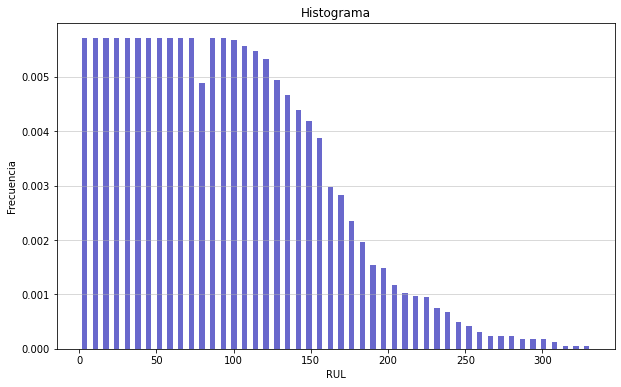

In [ ]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=y_total1, bins='auto', color='#0504aa',
                            alpha=0.6, rwidth=0.5,density=True)
plt.grid(axis='y', alpha=0.6)
plt.xlabel('RUL')
plt.ylabel('Frecuencia')
plt.title('Histograma')
maxfreq = n.max()
# Set a clean upper y-axis limit.

plt.show()

#### Histograma dataset FD002

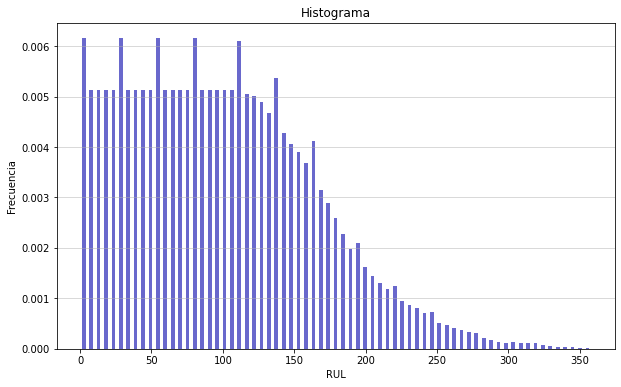

In [ ]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=y_total2, bins='auto', color='#0504aa',
                            alpha=0.6, rwidth=0.5,density=True)
plt.grid(axis='y', alpha=0.6)
plt.xlabel('RUL')
plt.ylabel('Frecuencia')
plt.title('Histograma')
maxfreq = n.max()
# Set a clean upper y-axis limit.

#### Histograma dataset FD003

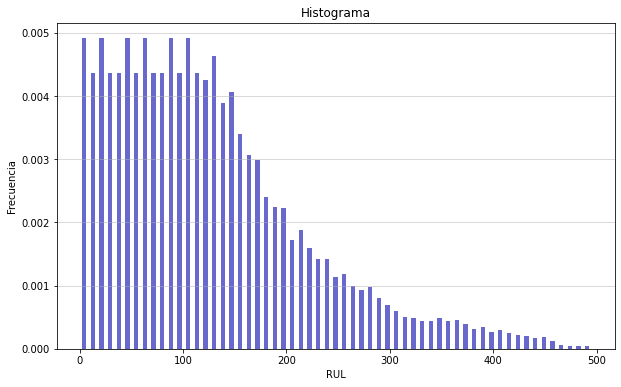

In [ ]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=y_total3, bins="auto", color='#0504aa',
                            alpha=0.6, rwidth=0.5,density=True)
plt.grid(axis='y', alpha=0.6)
plt.xlabel('RUL')
plt.ylabel('Frecuencia')
plt.title('Histograma')
maxfreq = n.max()
# Set a clean upper y-axis limit.

#### Histograma dataset FD004

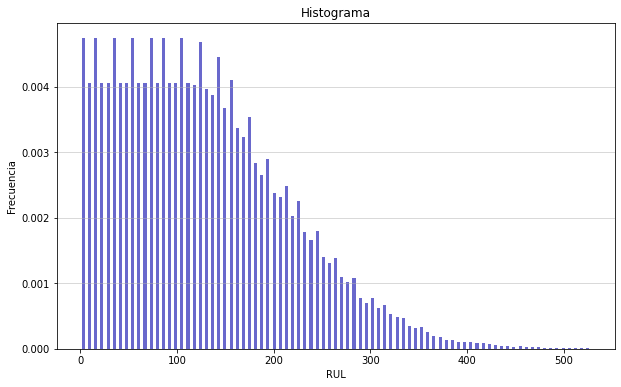

In [ ]:
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(x=y_total4, bins='auto', color='#0504aa',
                            alpha=0.6, rwidth=0.5,density=True)
plt.grid(axis='y', alpha=0.6)
plt.xlabel('RUL')
plt.ylabel('Frecuencia')
plt.title('Histograma')
maxfreq = n.max()
# Set a clean upper y-axis limit.

PCA Turbofan

In [ ]:
df = pd.read_csv("train_FD001.txt", sep = ' ', header = None)
df = df.drop(columns=[26, 27])
df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  
  #Agregada variable RUL a df y normalización de columnas (salvo RUL)

df

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [ ]:
RUL_temp=np.zeros(0)
for i in range(1,df['n_engine'].max() + 1):
  minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
  RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
  RUL_temp = np.append(RUL_temp,RUL_engine-minus)
#df['RUL'] = RUL_temp
#df['RUL'] = df['RUL'].astype(int)

In [ ]:
Features_momentums = (pd.DataFrame(columns=('sens_2_u', 'sens_2_o','sens_2_s','sens_2_k',
                                  'sens_3_u', 'sens_3_o','sens_3_s','sens_3_k',
                                  'sens_4_u', 'sens_4_o','sens_4_s','sens_4_k',
                                  'sens_7_u', 'sens_7_o','sens_7_s','sens_7_k',
                                  'sens_8_u', 'sens_8_o','sens_8_s','sens_8_k',
                                  'sens_9_u', 'sens_9_o','sens_9_s','sens_9_k',
                                  'sens_11_u', 'sens_11_o','sens_11_s','sens_11_k',
                                  'sens_12_u', 'sens_12_o','sens_12_s','sens_12_k',
                                  'sens_13_u', 'sens_13_o','sens_13_s','sens_13_k',
                                  'sens_14_u', 'sens_14_o','sens_14_s','sens_14_k',
                                  'sens_15_u', 'sens_15_o','sens_15_s','sens_15_k',
                                  'sens_17_u', 'sens_17_o','sens_17_s','sens_17_k',
                                  'sens_20_u', 'sens_20_o','sens_20_s','sens_20_k',
                                  'sens_21_u', 'sens_21_o','sens_21_s','sens_21_k',)))

Features = (pd.DataFrame(columns=('sens_2','sens_3','sens_4','sens_7','sens_8','sens_9','sens_11','sens_12','sens_13','sens_14','sens_15','sens_17','sens_20','sens_21',)))


In [ ]:
df

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [ ]:
df_rul = df.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)


In [ ]:
df_rul

,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [ ]:
RUL_temp=np.zeros(0)
for i in range(1,df['n_engine'].max() + 1):
  minus = np.linspace(1,df[df['n_engine']==i]['cycle'].max(),df[df['n_engine']==i]['cycle'].max())
  RUL_engine = np.ones((df[df['n_engine']==i]['cycle'].max()))*df[df['n_engine']==i]['cycle'].max()
  RUL_temp = np.append(RUL_temp,RUL_engine-minus)
#df['RUL'] = RUL_temp
#df['RUL'] = df['RUL'].astype(int)

In [ ]:
df_rul = StandardScaler().fit_transform(df_rul)

#### PCA training set dataset FD001

In [ ]:
pca = PCA(n_components=4)
principalComponents_4 = pca.fit_transform(df_rul)
principalDf_4 = pd.DataFrame(data = principalComponents_4, columns = ['pc1', 'pc2','pc3','pc4'])

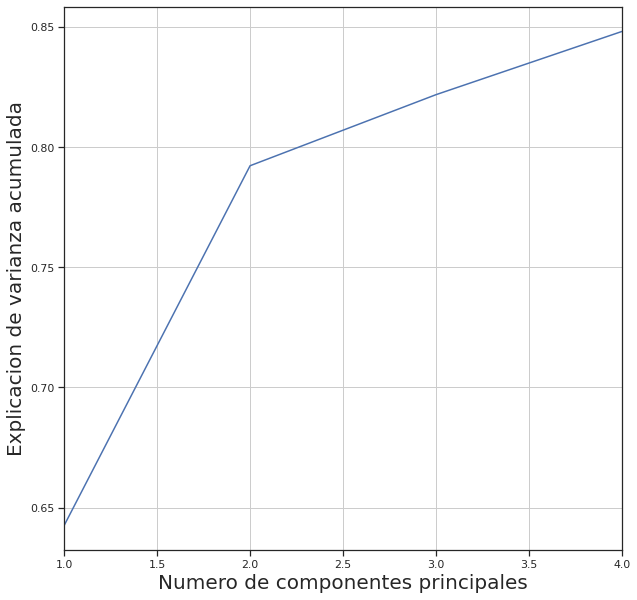

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,4,4),np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('Numero de componentes principales',fontsize=20)
plt.ylabel('Explicacion de varianza acumulada',fontsize=20)
plt.xlim([1, 4])
plt.show()

No handles with labels found to put in legend.


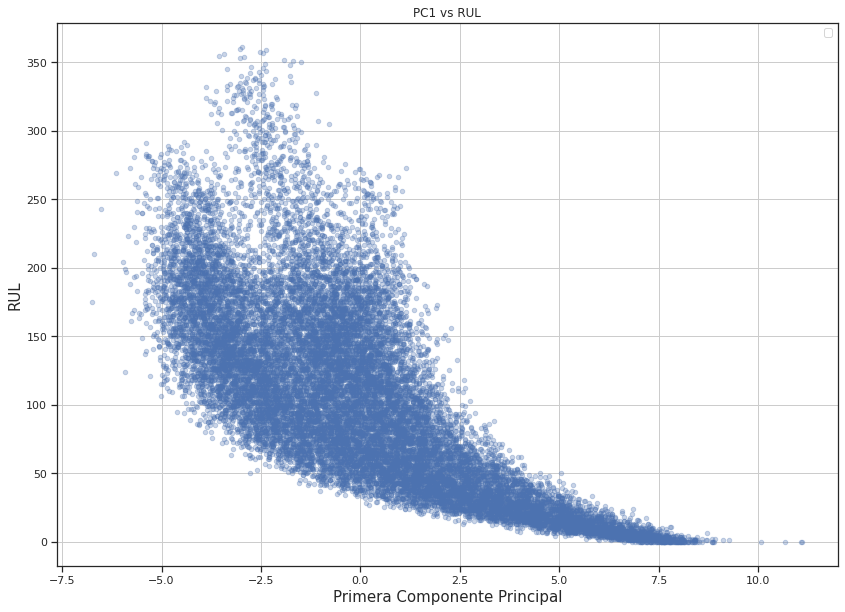

In [ ]:
fig,ax=plt.subplots(figsize=(14,10))
fig.patch.set_facecolor('white')
ax.scatter(principalDf_4['pc1'],RUL_temp,s=20,marker='o',alpha=.3)
plt.xlabel("Primera Componente Principal",fontsize=15)
plt.ylabel("RUL",fontsize=15)
plt.grid(True)
plt.title('PC1 vs RUL')
plt.legend()
plt.show()

In [ ]:
df

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640


In [ ]:
df_2 = pd.read_csv("train_FD002.txt", sep = ' ', header = None)
df_2 = df_2.drop(columns=[26, 27])
df_2.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df_2 = df_2.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  
  #Agregada variable RUL a df y normalización de columnas (salvo RUL)

df_2

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,1,34.9983,0.8400,100.0,555.32,1358.61,1137.23,194.64,2222.65,8341.91,42.02,183.06,2387.72,8048.56,9.3461,334,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,549.90,1353.22,1125.78,138.51,2211.57,8303.96,42.20,130.42,2387.66,8072.30,9.3774,330,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,537.31,1256.76,1047.45,175.71,1915.11,8001.42,36.69,164.22,2028.03,7864.87,10.8941,309,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,549.51,1354.03,1126.38,138.46,2211.58,8303.96,41.96,130.72,2387.61,8068.66,9.3528,329,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,537.07,1257.71,1047.93,175.05,1915.10,7993.23,36.89,164.31,2028.00,7861.23,10.8963,309,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,260,312,20.0037,0.7000,100.0,608.79,1495.60,1269.51,334.00,2324.92,8852.27,44.72,314.05,2389.02,8169.64,9.3035,369,24.36,14.5189
53755,260,313,10.0022,0.2510,100.0,605.81,1514.32,1324.12,392.46,2319.17,8915.86,46.08,371.22,2388.42,8245.36,8.7586,374,28.10,16.9454
53756,260,314,25.0041,0.6200,60.0,537.48,1276.24,1057.92,175.11,1917.37,8114.33,37.14,163.74,2030.33,7971.25,11.0657,310,14.19,8.5503
53757,260,315,25.0033,0.6220,60.0,537.84,1272.95,1066.30,174.81,1917.36,8112.63,37.32,164.37,2030.35,7972.47,11.0537,311,14.05,8.3729


In [ ]:
RUL_temp=np.zeros(0)
for i in range(1,df_2['n_engine'].max() + 1):
  minus = np.linspace(1,df_2[df_2['n_engine']==i]['cycle'].max(),df_2[df_2['n_engine']==i]['cycle'].max())
  RUL_engine = np.ones((df_2[df_2['n_engine']==i]['cycle'].max()))*df_2[df_2['n_engine']==i]['cycle'].max()
  RUL_temp = np.append(RUL_temp,RUL_engine-minus)
#df['RUL'] = RUL_temp
#df['RUL'] = df['RUL'].astype(int)

In [ ]:
df_rul2 = df_2.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
df_rul2

,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,555.32,1358.61,1137.23,194.64,2222.65,8341.91,42.02,183.06,2387.72,8048.56,9.3461,334,14.73,8.8071
1,549.90,1353.22,1125.78,138.51,2211.57,8303.96,42.20,130.42,2387.66,8072.30,9.3774,330,10.41,6.2665
2,537.31,1256.76,1047.45,175.71,1915.11,8001.42,36.69,164.22,2028.03,7864.87,10.8941,309,14.08,8.6723
3,549.51,1354.03,1126.38,138.46,2211.58,8303.96,41.96,130.72,2387.61,8068.66,9.3528,329,10.59,6.4701
4,537.07,1257.71,1047.93,175.05,1915.10,7993.23,36.89,164.31,2028.00,7861.23,10.8963,309,14.13,8.5286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53754,608.79,1495.60,1269.51,334.00,2324.92,8852.27,44.72,314.05,2389.02,8169.64,9.3035,369,24.36,14.5189
53755,605.81,1514.32,1324.12,392.46,2319.17,8915.86,46.08,371.22,2388.42,8245.36,8.7586,374,28.10,16.9454
53756,537.48,1276.24,1057.92,175.11,1917.37,8114.33,37.14,163.74,2030.33,7971.25,11.0657,310,14.19,8.5503
53757,537.84,1272.95,1066.30,174.81,1917.36,8112.63,37.32,164.37,2030.35,7972.47,11.0537,311,14.05,8.3729


In [ ]:
df_rul2 = StandardScaler().fit_transform(df_rul2)

#### PCA training set dataset FD002

In [ ]:
pca = PCA(n_components=4)
principalComponents_4 = pca.fit_transform(df_rul2)
principalDf_4 = pd.DataFrame(data = principalComponents_4, columns = ['pc1', 'pc2','pc3','pc4'])

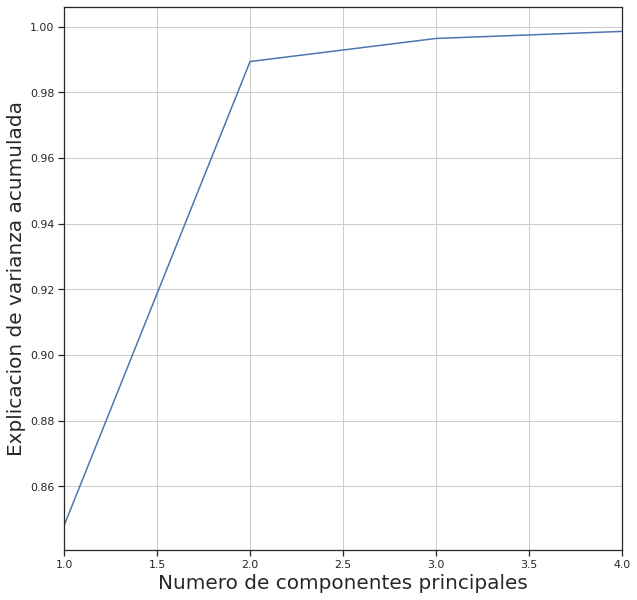

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,4,4),np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('Numero de componentes principales',fontsize=20)
plt.ylabel('Explicacion de varianza acumulada',fontsize=20)
plt.xlim([1, 4])
plt.show()

No handles with labels found to put in legend.


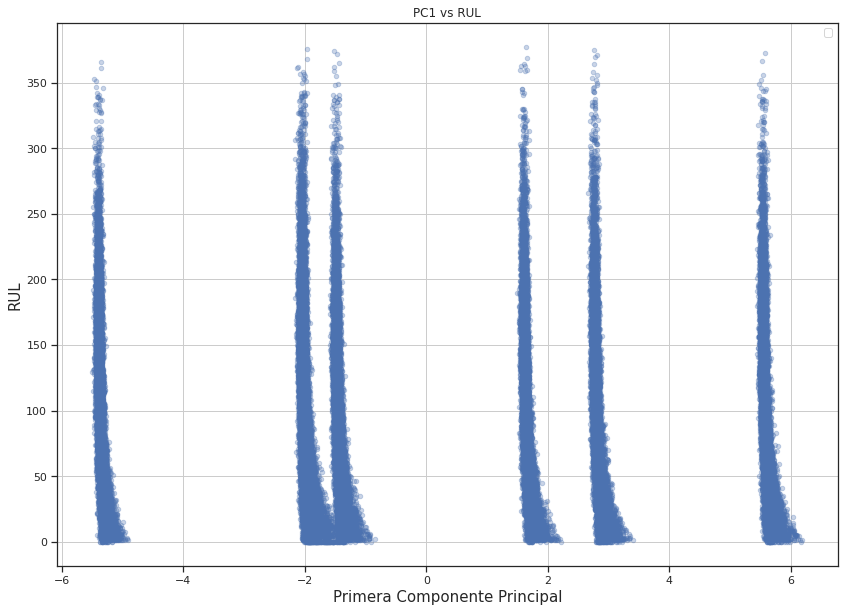

In [ ]:
fig,ax=plt.subplots(figsize=(14,10))
fig.patch.set_facecolor('white')
ax.scatter(principalDf_4['pc1'],RUL_temp,s=20,marker='o',alpha=.3)
plt.xlabel("Primera Componente Principal",fontsize=15)
plt.ylabel("RUL",fontsize=15)
plt.grid(True)
plt.title('PC1 vs RUL')
plt.legend()
plt.show()

In [ ]:
df_3 = pd.read_csv("train_FD003.txt", sep = ' ', header = None)
df_3 = df_3.drop(columns=[26, 27])
df_3.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df_3 = df_3.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  
  #Agregada variable RUL a df y normalización de columnas (salvo RUL)

df_3

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,1,-0.0005,0.0004,100.0,642.36,1583.23,1396.84,553.97,2387.96,9062.17,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537
1,1,2,0.0008,-0.0003,100.0,642.50,1584.69,1396.89,554.55,2388.00,9061.78,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491
2,1,3,-0.0014,-0.0002,100.0,642.18,1582.35,1405.61,554.43,2388.03,9070.23,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669
3,1,4,-0.0020,0.0001,100.0,642.92,1585.61,1392.27,555.21,2388.00,9064.57,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951
4,1,5,0.0016,0.0000,100.0,641.68,1588.63,1397.65,554.74,2388.04,9076.14,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,100,148,-0.0016,-0.0003,100.0,643.78,1596.01,1424.11,551.86,2388.25,9070.82,48.27,519.66,2388.30,8138.08,8.5036,394,38.44,22.9631
24716,100,149,0.0034,-0.0003,100.0,643.29,1596.38,1429.14,551.86,2388.23,9064.60,48.13,519.91,2388.28,8144.36,8.5174,395,38.50,22.9746
24717,100,150,-0.0016,0.0004,100.0,643.84,1604.53,1431.41,551.30,2388.25,9063.45,48.18,519.44,2388.24,8135.95,8.5223,396,38.39,23.0682
24718,100,151,-0.0023,0.0004,100.0,643.94,1597.56,1426.57,550.69,2388.26,9062.22,48.05,520.01,2388.26,8141.24,8.5148,395,38.31,23.0753


In [ ]:
RUL_temp=np.zeros(0)
for i in range(1,df_3['n_engine'].max() + 1):
  minus = np.linspace(1,df_3[df_3['n_engine']==i]['cycle'].max(),df_3[df_3['n_engine']==i]['cycle'].max())
  RUL_engine = np.ones((df_3[df_3['n_engine']==i]['cycle'].max()))*df_3[df_3['n_engine']==i]['cycle'].max()
  RUL_temp = np.append(RUL_temp,RUL_engine-minus)
#df['RUL'] = RUL_temp
#df['RUL'] = df['RUL'].astype(int)

In [ ]:
df_rul3 = df_3.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
df_rul3

,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,642.36,1583.23,1396.84,553.97,2387.96,9062.17,47.30,522.31,2388.01,8145.32,8.4246,391,39.11,23.3537
1,642.50,1584.69,1396.89,554.55,2388.00,9061.78,47.23,522.42,2388.03,8152.85,8.4403,392,38.99,23.4491
2,642.18,1582.35,1405.61,554.43,2388.03,9070.23,47.22,522.03,2388.00,8150.17,8.3901,391,38.85,23.3669
3,642.92,1585.61,1392.27,555.21,2388.00,9064.57,47.24,522.49,2388.08,8146.56,8.3878,392,38.96,23.2951
4,641.68,1588.63,1397.65,554.74,2388.04,9076.14,47.15,522.58,2388.03,8147.80,8.3869,392,39.14,23.4583
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24715,643.78,1596.01,1424.11,551.86,2388.25,9070.82,48.27,519.66,2388.30,8138.08,8.5036,394,38.44,22.9631
24716,643.29,1596.38,1429.14,551.86,2388.23,9064.60,48.13,519.91,2388.28,8144.36,8.5174,395,38.50,22.9746
24717,643.84,1604.53,1431.41,551.30,2388.25,9063.45,48.18,519.44,2388.24,8135.95,8.5223,396,38.39,23.0682
24718,643.94,1597.56,1426.57,550.69,2388.26,9062.22,48.05,520.01,2388.26,8141.24,8.5148,395,38.31,23.0753


In [ ]:
df_rul3 = StandardScaler().fit_transform(df_rul3)

#### PCA training set dataset FD003

In [ ]:
pca = PCA(n_components=4)
principalComponents_4 = pca.fit_transform(df_rul3)
principalDf_4 = pd.DataFrame(data = principalComponents_4, columns = ['pc1', 'pc2','pc3','pc4'])

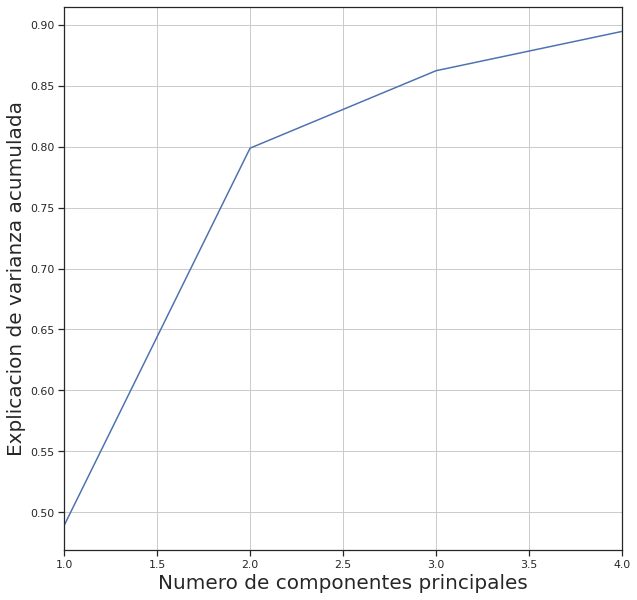

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,4,4),np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('Numero de componentes principales',fontsize=20)
plt.ylabel('Explicacion de varianza acumulada',fontsize=20)
plt.xlim([1, 4])
plt.show()

No handles with labels found to put in legend.


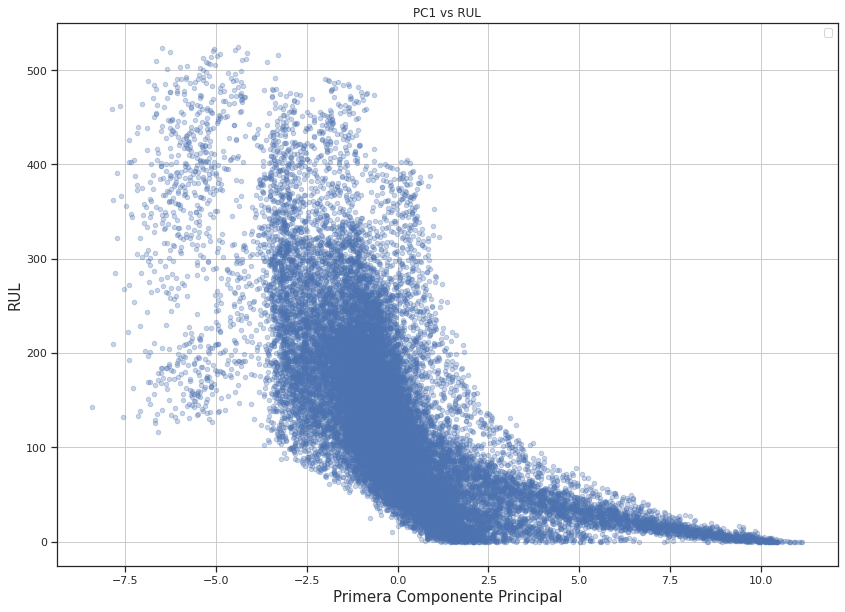

In [ ]:
fig,ax=plt.subplots(figsize=(14,10))
fig.patch.set_facecolor('white')
ax.scatter(principalDf_4['pc1'],RUL_temp,s=20,marker='o',alpha=.3)
plt.xlabel("Primera Componente Principal",fontsize=15)
plt.ylabel("RUL",fontsize=15)
plt.grid(True)
plt.title('PC1 vs RUL')
plt.legend()
plt.show()

In [ ]:
df_4 = pd.read_csv("train_FD004.txt", sep = ' ', header = None)
df_4 = df_4.drop(columns=[26, 27])
df_4.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df_4 = df_4.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  
  #Agregada variable RUL a df y normalización de columnas (salvo RUL)

df_4

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,1,42.0049,0.8400,100.0,549.68,1343.43,1112.93,137.36,2211.86,8311.32,41.69,129.78,2387.99,8074.83,9.3335,330,10.62,6.3670
1,1,2,20.0020,0.7002,100.0,606.07,1477.61,1237.50,332.10,2323.66,8713.60,43.94,312.59,2387.73,8046.13,9.1913,361,24.37,14.6552
2,1,3,42.0038,0.8409,100.0,548.95,1343.12,1117.05,138.18,2211.92,8306.69,41.66,129.62,2387.97,8066.62,9.4007,329,10.48,6.4213
3,1,4,42.0000,0.8400,100.0,548.70,1341.24,1118.03,137.98,2211.88,8312.35,41.68,129.80,2388.02,8076.05,9.3369,328,10.54,6.4176
4,1,5,25.0063,0.6207,60.0,536.10,1255.23,1033.59,174.82,1915.22,7994.94,36.48,164.11,2028.08,7865.80,10.8366,305,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,249,251,9.9998,0.2500,100.0,605.33,1516.36,1315.28,404.59,2319.66,8840.16,46.08,380.16,2388.73,8185.69,8.4541,372,29.11,17.5234
61245,249,252,0.0028,0.0015,100.0,643.42,1598.92,1426.77,567.59,2388.47,9117.12,48.04,535.02,2388.46,8185.47,8.2221,396,39.38,23.7151
61246,249,253,0.0029,0.0000,100.0,643.68,1607.72,1430.56,569.04,2388.51,9126.53,48.24,535.41,2388.48,8193.94,8.2525,395,39.78,23.8270
61247,249,254,35.0046,0.8400,100.0,555.77,1381.29,1148.18,199.93,2223.78,8403.64,42.53,187.92,2388.83,8125.64,9.0515,337,15.26,9.0774


In [ ]:
RUL_temp=np.zeros(0)
for i in range(1,df_4['n_engine'].max() + 1):
  minus = np.linspace(1,df_4[df_4['n_engine']==i]['cycle'].max(),df_4[df_4['n_engine']==i]['cycle'].max())
  RUL_engine = np.ones((df_4[df_4['n_engine']==i]['cycle'].max()))*df_4[df_4['n_engine']==i]['cycle'].max()
  RUL_temp = np.append(RUL_temp,RUL_engine-minus)
#df['RUL'] = RUL_temp
#df['RUL'] = df['RUL'].astype(int)

In [ ]:
df_rul4 = df_4.drop(['n_engine','cycle','opset_1','opset_2','opset_3'],axis=1)
df_rul4

,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,549.68,1343.43,1112.93,137.36,2211.86,8311.32,41.69,129.78,2387.99,8074.83,9.3335,330,10.62,6.3670
1,606.07,1477.61,1237.50,332.10,2323.66,8713.60,43.94,312.59,2387.73,8046.13,9.1913,361,24.37,14.6552
2,548.95,1343.12,1117.05,138.18,2211.92,8306.69,41.66,129.62,2387.97,8066.62,9.4007,329,10.48,6.4213
3,548.70,1341.24,1118.03,137.98,2211.88,8312.35,41.68,129.80,2388.02,8076.05,9.3369,328,10.54,6.4176
4,536.10,1255.23,1033.59,174.82,1915.22,7994.94,36.48,164.11,2028.08,7865.80,10.8366,305,14.03,8.6754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61244,605.33,1516.36,1315.28,404.59,2319.66,8840.16,46.08,380.16,2388.73,8185.69,8.4541,372,29.11,17.5234
61245,643.42,1598.92,1426.77,567.59,2388.47,9117.12,48.04,535.02,2388.46,8185.47,8.2221,396,39.38,23.7151
61246,643.68,1607.72,1430.56,569.04,2388.51,9126.53,48.24,535.41,2388.48,8193.94,8.2525,395,39.78,23.8270
61247,555.77,1381.29,1148.18,199.93,2223.78,8403.64,42.53,187.92,2388.83,8125.64,9.0515,337,15.26,9.0774


In [ ]:
df_rul4 = StandardScaler().fit_transform(df_rul4)

#### PCA training set dataset FD004

In [ ]:
pca = PCA(n_components=4)
principalComponents_4 = pca.fit_transform(df_rul4)
principalDf_4 = pd.DataFrame(data = principalComponents_4, columns = ['pc1', 'pc2','pc3','pc4'])

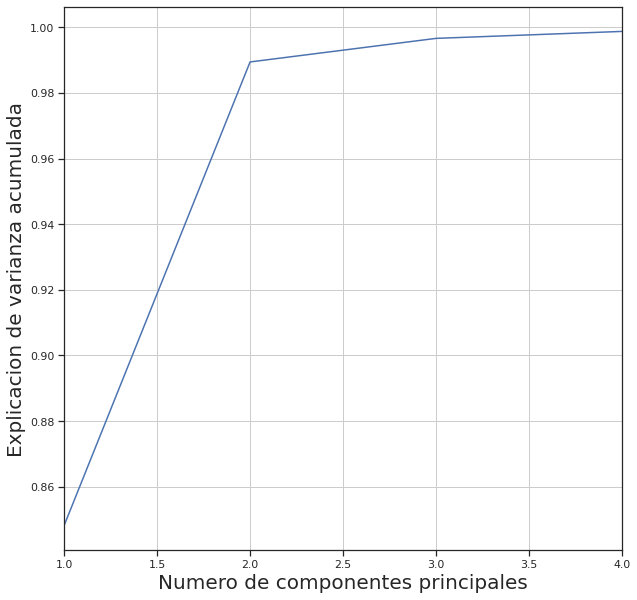

In [ ]:
plt.figure(figsize = (10,10))
plt.plot(np.linspace(1,4,4),np.cumsum(pca.explained_variance_ratio_))
plt.grid(True)
plt.xlabel('Numero de componentes principales',fontsize=20)
plt.ylabel('Explicacion de varianza acumulada',fontsize=20)
plt.xlim([1, 4])
plt.show()

No handles with labels found to put in legend.


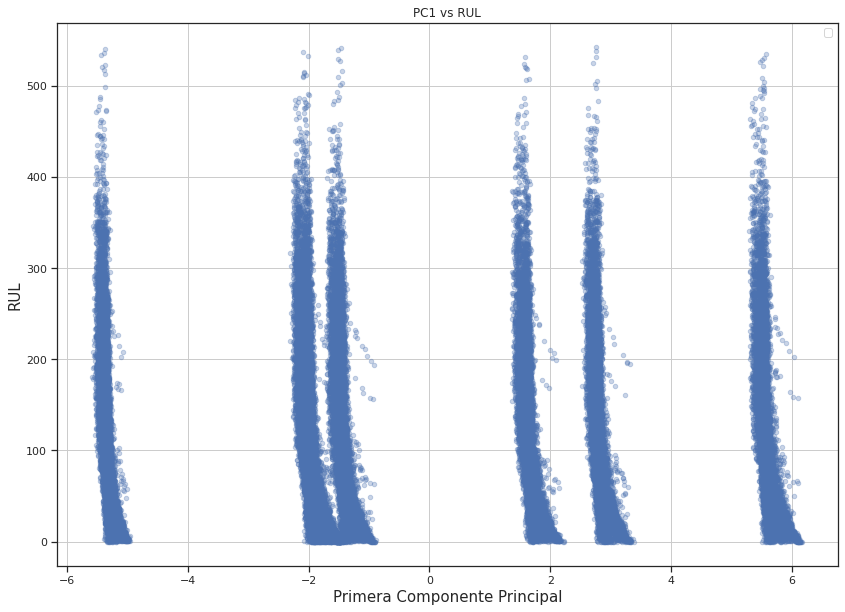

In [ ]:
fig,ax=plt.subplots(figsize=(14,10))
fig.patch.set_facecolor('white')
ax.scatter(principalDf_4['pc1'],RUL_temp,s=20,marker='o',alpha=.3)
plt.xlabel("Primera Componente Principal",fontsize=15)
plt.ylabel("RUL",fontsize=15)
plt.grid(True)
plt.title('PC1 vs RUL')
plt.legend()
plt.show()

In [ ]:
df = pd.read_csv("train_FD001.txt", sep = ' ', header = None)
df = df.drop(columns=[26, 27])
df.columns = (["n_engine","cycle","opset_1","opset_2","opset_3",
              "sens_1","sens_2","sens_3","sens_4","sens_5","sens_6","sens_7","sens_8","sens_9","sens_10",
              "sens_11","sens_12","sens_13","sens_14","sens_15","sens_16","sens_17","sens_18","sens_19","sens_20","sens_21"])
df = df.drop(['sens_1','sens_5','sens_6','sens_10','sens_16','sens_18','sens_19'],axis=1)
  
  #Agregada variable RUL a df y normalización de columnas (salvo RUL)

df

,n_engine,cycle,opset_1,opset_2,opset_3,sens_2,sens_3,sens_4,sens_7,sens_8,sens_9,sens_11,sens_12,sens_13,sens_14,sens_15,sens_17,sens_20,sens_21
0,1,1,-0.0007,-0.0004,100.0,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640
